In [105]:
import jax.numpy as np
import matplotlib.pyplot as plt
import dLux as dl
import dLux.utils as dlu
import jax.random as jr
import dLuxToliman as dlT
import optax
import zodiax as zdx
import jax
from tqdm.notebook import tqdm

In [106]:
wf_npix = 256 # gonna do double the psf_npix
diameter = 0.125
coords = dlu.pixel_coords(wf_npix, diameter)
aperture = dlu.circle(coords, 0.5*diameter)
wavelength = 585e-9

# this is basically half of louis 
psf_npix = 128
psf_pixel_scale = dlu.rad2arcsec(wavelength/(2*diameter))
# nyquist = lambda/2D
oversample = 4 #fairly shite.. hopefully doesn't come back to bite us

pupil = dlT.TolimanPupilLayer(wf_npix)

layers = [
    (
        'aperture',
        dl.layers.TransmissiveLayer(aperture, normalise=True)
    )
]

layers_tol = [
    (
        'aperture',
        dl.layers.TransmissiveLayer(aperture, normalise=True)
    ),
    (
        'pupil',
        pupil
    )
]

optics = dl.AngularOpticalSystem(
    wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample
)

optics_tol = dl.AngularOpticalSystem(
    wf_npix, diameter, layers_tol, psf_npix, psf_pixel_scale, oversample
)

detector_radius = 0.75 * dlu.arcsec2rad(psf_npix*psf_pixel_scale/2)

# half of louis number 
n_sources = 25
n_trials = 10

#downsamples = np.array([2])
downsamples = np.array([1, 2, 4, 8, 16, 32])

def crb_position(wavelength, diameter, flux):
    crb_pos = (np.sqrt(2)/(np.pi * np.sqrt(flux)))*(wavelength/diameter)
    return crb_pos

def crb_flux(flux):
    crb_flux = np.sqrt(flux)
    return crb_flux

bg_noise = 0 # mean photons of background noise per oversampled pixel. YES that is what it is.

In [107]:
# initialising
r_res_crb_alltrials = []
flux_res_crb_alltrials = []
r_res_crb_alltrials_tol = []
flux_res_crb_alltrials_tol = []

for i in np.arange(n_trials):
    key = i
    position_array = jr.uniform(jr.PRNGKey(key), (n_sources,2), minval=-detector_radius, maxval=detector_radius)

    # clamping fluxes, above 10 photons
    flux_array = np.abs(50000 * jr.normal(jr.PRNGKey(key), (n_sources,)))
    flux_array = np.where(flux_array < 10, 10, flux_array)

    # get the cramer rao bounds
    pos_crbs = crb_position(wavelength, diameter, flux_array)
    flux_crbs = crb_flux(flux_array)

    sources = dl.PointSources(np.array([wavelength]), position_array, flux_array, np.array([1]))
    
    positions = 'source.position'
    fluxes = 'source.flux'

    parameters = [positions, fluxes]

    r_res_crb_total = []
    flux_res_crb_total = []

    r_res_crb_total_tol = []
    flux_res_crb_total_tol = []

    for idx, downsample in enumerate(downsamples):
        key_2 = idx

        # create downsample layer
        downsample_layer = dl.layers.detector_layers.Downsample(downsample)
        bg_noise_layer = dl.layers.detector_layers.AddConstant(bg_noise)

        # background noise should be applied after the downsample? hopefully..?. No want before
        detector = dl.LayeredDetector([bg_noise_layer,downsample_layer])

        # make telescope
        telescope = dl.Telescope(optics, sources, detector)
        telescope_tol = dl.Telescope(optics_tol, sources, detector)

        psf_noisy = jr.poisson(jr.PRNGKey(key), telescope.model())
        psf_tol_noisy = jr.poisson(jr.PRNGKey(key), telescope_tol.model())

        # perturb positions by maximum 0.5 of a pixel in each direction.
        model = telescope.add(positions, 
                              jr.uniform(jr.PRNGKey(key_2), (n_sources, 2), 
                                         minval=-0.5*dlu.arcsec2rad(psf_pixel_scale), 
                                         maxval=0.5*dlu.arcsec2rad(psf_pixel_scale)))
        model_tol = telescope_tol.add(positions, 
                              jr.uniform(jr.PRNGKey(key_2), (n_sources, 2), 
                                         minval=-0.5*dlu.arcsec2rad(psf_pixel_scale), 
                                         maxval=0.5*dlu.arcsec2rad(psf_pixel_scale)))
        # perturb fluxes by +/- 20%
        model = model.multiply(fluxes, 1 + jr.uniform(jr.PRNGKey(key_2), (n_sources,),
                                                      minval=-0.2,
                                                      maxval=0.2))
        model_tol = model_tol.multiply(fluxes, 1 + jr.uniform(jr.PRNGKey(key_2), (n_sources,),
                                                      minval=-0.2,
                                                      maxval=0.2))

        #optimisers
        pos_optimiser   = optax.adam((1e-7)/2)
        flux_optimiser  = optax.adam((1e3)/2)
        optimisers = [pos_optimiser, flux_optimiser]

        # one for each
        optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)
        optim_tol, opt_state_tol = zdx.get_optimiser(model_tol, parameters, optimisers)

        @zdx.filter_jit
        @zdx.filter_value_and_grad(parameters)
        # define the loss function
        def loss_fn(model, data):
            # make sure to downsample
            out = model.model()
            # poisson log likelihood
            return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))
        
        # initial compile
        loss, grads = loss_fn(model, psf_noisy) # Compile
        print("Initial Loss: {}".format(int(loss)))

        losses, models_out = [], []
        with tqdm(range(200),desc='Gradient Descent') as t:
            for i in t: 
                loss, grads = loss_fn(model, psf_noisy)    
                updates, opt_state = optim.update(grads, opt_state)
                # clamp flux updates to prohibit NaNs
                model_fluxes = model.get(fluxes)
                update_fluxes = updates.get(fluxes)
                epsilon = 1
                safe_updates = np.where(model_fluxes + update_fluxes < epsilon, epsilon-model_fluxes, update_fluxes)
                updates = updates.set(fluxes, safe_updates)

                model = zdx.apply_updates(model, updates)
                losses.append(loss)
                models_out.append(model)
                t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

        # getting final stuff
        final_model = models_out[-1]
        flux_residuals = flux_array - final_model.get(fluxes)
        flux_res_crb = np.abs(flux_residuals)/flux_crbs
        # append
        flux_res_crb_total.append(flux_res_crb)

        position_residuals = position_array - final_model.get(positions)
        r_residuals = np.hypot(position_residuals[:,0], position_residuals[:,1])
        r_res_crb = r_residuals/pos_crbs
        # append to total
        r_res_crb_total.append(r_res_crb)

        # initial compile, now for toliman
        loss_tol, grads_tol = loss_fn(model_tol, psf_tol_noisy) # Compile
        print("Initial Loss: {}".format(int(loss_tol)))

        losses_tol, models_out_tol = [], []
        with tqdm(range(200),desc='Gradient Descent') as t:
            for i in t: 
                loss_tol, grads_tol = loss_fn(model_tol, psf_tol_noisy)    
                updates, opt_state_tol = optim_tol.update(grads_tol, opt_state_tol)
                
                # clamp flux updates to prohibit NaNs
                model_fluxes = model_tol.get(fluxes)
                update_fluxes = updates.get(fluxes)
                epsilon = 1
                safe_updates = np.where(model_fluxes + update_fluxes < epsilon, epsilon-model_fluxes, update_fluxes)
                updates = updates.set(fluxes, safe_updates)

                model_tol = zdx.apply_updates(model_tol, updates)
                losses_tol.append(loss_tol)
                models_out_tol.append(model_tol)
                t.set_description("Log Loss: {:.3f}".format(np.log10(loss_tol))) # update the progress bar

        # getting the final stats!
        final_model_tol = models_out_tol[-1]
        flux_residuals_tol = flux_array - final_model_tol.get(fluxes)
        flux_res_crb_tol = np.abs(flux_residuals_tol)/flux_crbs
        # append
        flux_res_crb_total_tol.append(flux_res_crb_tol)

        position_residuals_tol = position_array - final_model_tol.get(positions)
        r_residuals_tol = np.hypot(position_residuals_tol[:,0], position_residuals_tol[:,1])
        r_res_crb_tol = r_residuals_tol/pos_crbs
        # append to total
        r_res_crb_total_tol.append(r_res_crb_tol)

    # append for each particular trial
    r_res_crb_alltrials.append(r_res_crb_total)
    flux_res_crb_alltrials.append(flux_res_crb_total)

    r_res_crb_alltrials_tol.append(r_res_crb_total_tol)
    flux_res_crb_alltrials_tol.append(flux_res_crb_total_tol)


Initial Loss: 302543


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 445489


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 219203


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 189059


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 150889


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 88734


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 81731


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 32708


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 36041


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 8145


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 24469


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 5029


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 367650


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 496812


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 296510


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 235746


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 152455


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 90975


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 101013


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 40280


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 50037


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 8580


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 25182


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 3455


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 325064


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 448340


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 264012


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 208302


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 149939


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 92459


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 89366


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 34054


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 49528


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 8744


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 37560


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 4911


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 414256


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 511211


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 301251


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 225601


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 178884


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 96679


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 113904


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 40028


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 61040


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 9682


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 15384


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 3874


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 268091


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 416954


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 198375


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 188804


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 114758


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 78885


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 70741


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 30520


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 40855


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 10113


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 20109


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 4319


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 266338


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 419046


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 193165


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 182510


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 124899


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 79906


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 62804


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 26631


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 33513


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 8945


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 18303


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 5518


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 287101


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 424454


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 180509


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 176256


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 121739


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 79294


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 72193


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 30769


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 38812


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 9052


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 29278


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 4337


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 312961


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 429161


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 231145


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 191178


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 150049


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 84394


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 87253


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 32182


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 31583


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 7651


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 14464


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 3514


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 323636


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 450447


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 243867


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 204087


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 152373


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 90173


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 81836


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 30380


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 37157


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 8908


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 31350


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 3874


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 267512


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 425574


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 214798


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 192370


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 140845


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 88571


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 80915


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 31932


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 40508


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 8837


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 25544


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Initial Loss: 3672


Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

In [108]:
import pickle

with open('crb_results.pkl', 'wb') as f:
    pickle.dump({
        'r_res_crb_alltrials': r_res_crb_alltrials,
        'flux_res_crb_alltrials': flux_res_crb_alltrials,
        'r_res_crb_alltrials_tol': r_res_crb_alltrials_tol,
        'flux_res_crb_alltrials_tol': flux_res_crb_alltrials_tol
    }, f)

In [ ]:
print(np.average(r_res_crb_total_tol[0]))
print(np.average(r_res_crb_total[0]))
print(np.average(flux_res_crb_total_tol[0]))
print(np.average(flux_res_crb_total[0]))

# toliman pupil seems objectively worse in every way..?
# gonna try with significantly less sources
# still a lot worse.
# perhaps we need dark current noise?
# apparently gets even worse? Yep definitely looks like it
# kinda obvious considering toliman spreads it out over more stuff
# Louis writes in his honours thesis that the 'per pixel noise' is kept constant when downsampling increases
# which would result in better SNR as downsampling increases, rather than constant.

2.9259827
1.1289295
2.0767305
0.9875042


In [45]:
positions_found  = np.array([model.get(positions) for model in models_out_tol])
fluxes_found     = np.array([model.get(fluxes)    for model in models_out_tol])
flux_residuals = flux_array - fluxes_found
positions_residuals = position_array - positions_found
r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])

1.856683


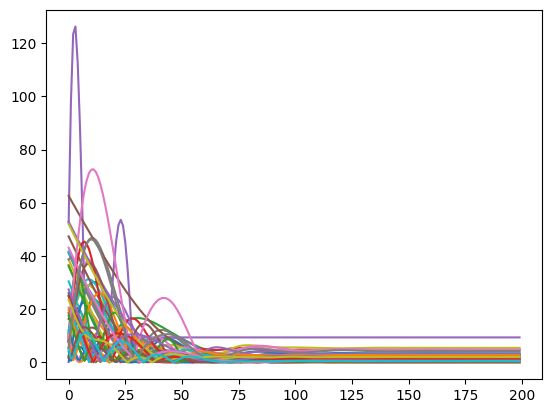

3.3539703


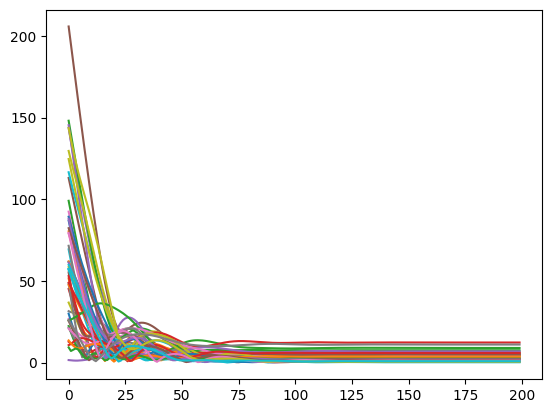

In [47]:
plt.plot(np.abs(flux_residuals)/flux_crbs)
print(np.average((np.abs(flux_residuals)/flux_crbs)[-1]))
# plt.ylim(0,10)
plt.show()
plt.plot(r_residuals_rads/pos_crbs)
print(np.average((r_residuals_rads/pos_crbs)[-1]))
# plt.ylim(0,10)
plt.show()

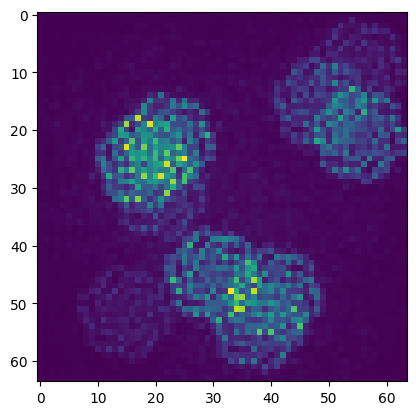

209128
209128.0


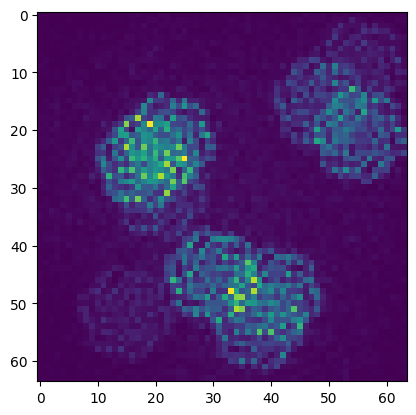

In [90]:
plt.imshow(model_tol.model())
plt.show()
plt.imshow(psf_tol_noisy)
print(np.sum(psf_tol_noisy))
print(np.sum(model_tol.model()))

In [80]:
psf = optics.model(sources)
psf_tol = optics_tol.model(sources)

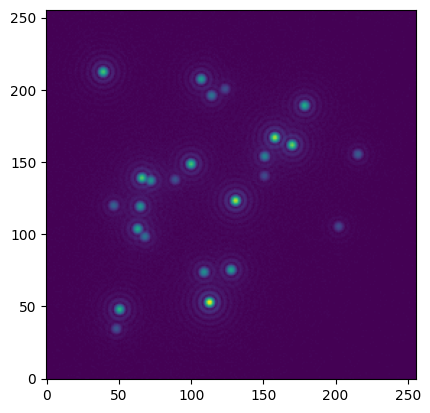

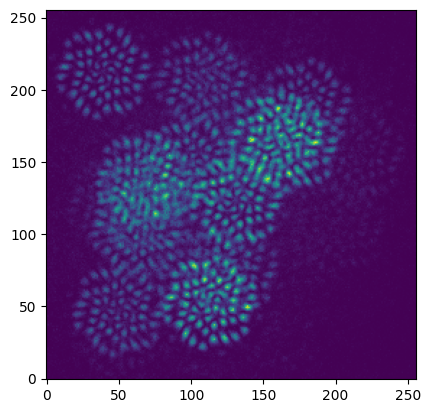

In [104]:
plt.imshow(dlu.downsample(psf_noisy, 1, False)**0.5,origin='lower')
plt.show()
plt.imshow(dlu.downsample(psf_tol_noisy, 1, False), origin='lower')
plt.show()

In [100]:
np.sum(psf_noisy[0,0])

Array(641, dtype=int32)

In [66]:
wavelength/diameter*512

0.00239616

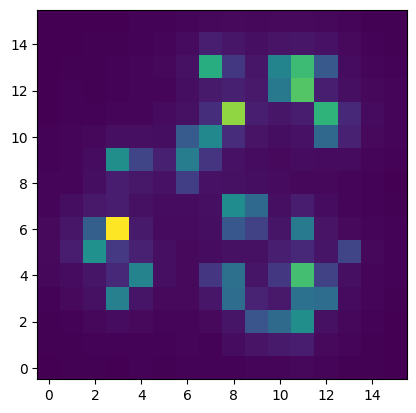

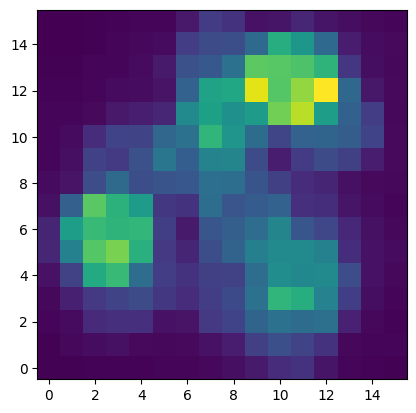

In [109]:
plt.imshow(dlu.downsample(psf_noisy, 1, False)**0.5,origin='lower')
plt.show()
plt.imshow(dlu.downsample(psf_tol_noisy, 1, False), origin='lower')
plt.show()